<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep4-eda-modeling?scriptVersionId=119306328" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

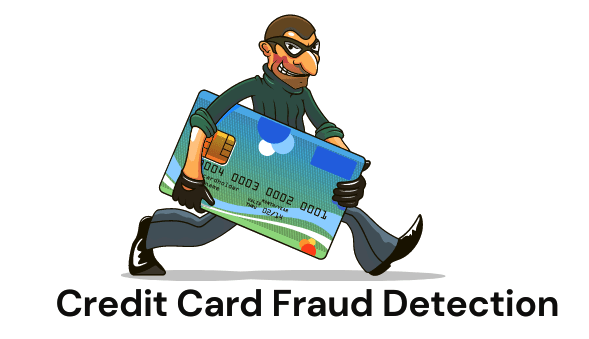

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#Notebook-Versions)

[2. Loading Libraries](#Loading-Libraries)

[3. Reading Data Files](#Reading-Data-Files)

[4. Data Exploration](#Data-Exploration)

[5. XGBoost Modeling](#XGBoost-Modeling)

[6. LightGBM Modeling](#LightGBM-Modeling)

[7. Model Performance Comparisson](#Model-Performance-Comparisson)

[8. Feature Engineering](#Feature-Engineering)


<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (01/23/2023)
    * EDA 
    * XGBoost Modeling
    
2. Version 2 (01/23/2023)
    * Fixing bug in submission
    
3. Version 3 (01/24/2023)
    * LightGBM Modeling added
    * Modeling Comparisson added
    
4. Version 4 (01/24/2023)
    * Fixed bug
    
5. Version 5 (01/24/2023)
    * Saving predictions
    
6. Version 6 (01/25/2023)
    * Feature engineering added (time feature)

7. Version 7 (01/30/2023)
    * Include perfect cross valdiation (https://www.kaggle.com/competitions/playground-series-s3e4/discussion/381415)
    
8. Version 8 (01/30/2023)
    * Fixing bud in drop statement.

9. Version 9 (02/15/2023)
    * Linking to GitHub
    
<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e4/train.csv')
test = pd.read_csv('../input/playground-series-s3e4/test.csv')
submission = pd.read_csv('../input/playground-series-s3e4/sample_submission.csv')

print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (219129, 32)
The dimession of the test dataset is: (146087, 31)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219129 entries, 0 to 219128
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      219129 non-null  int64  
 1   Time    219129 non-null  float64
 2   V1      219129 non-null  float64
 3   V2      219129 non-null  float64
 4   V3      219129 non-null  float64
 5   V4      219129 non-null  float64
 6   V5      219129 non-null  float64
 7   V6      219129 non-null  float64
 8   V7      219129 non-null  float64
 9   V8      219129 non-null  float64
 10  V9      219129 non-null  float64
 11  V10     219129 non-null  float64
 12  V11     219129 non-null  float64
 13  V12     219129 non-null  float64
 14  V13     219129 non-null  float64
 15  V14     219129 non-null  float64
 16  V15     219129 non-null  float64
 17  V16     219129 non-null  float64
 18  V17     219129 non-null  float64
 19  V18     219129 non-null  float64
 20  V19     219129 non-null  float64
 21  V20     21

In [4]:
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


In [5]:
train.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000
mean,109564.000000,62377.415376,0.096008,0.048345,0.592102,0.069273,-0.161555,0.133688,-0.128224,0.149534,-0.048337,-0.039758,0.153632,-0.061038,0.014330,0.067649,0.108643,0.013650,0.036815,-0.033927,-0.008302,0.009708,-0.031064,-0.050852,-0.050531,-0.002992,0.124005,0.009881,0.014034,0.017313,66.359803,0.002140
std,63257.237906,25620.348569,1.395425,1.159805,1.132884,1.253125,1.069530,1.202411,0.817207,0.716212,1.054143,0.821889,0.976946,0.998470,1.039145,0.801335,0.891613,0.786654,0.691709,0.784454,0.739928,0.439521,0.422777,0.597812,0.318175,0.593100,0.406741,0.473867,0.233355,0.164859,150.795017,0.046214
min,0.000000,0.000000,-29.807725,-44.247914,-19.722872,-5.263650,-37.591259,-25.659750,-31.179799,-28.903442,-8.756951,-22.092656,-4.190145,-16.180165,-4.373778,-15.585021,-4.155728,-11.778839,-20.756768,-7.456060,-4.281628,-18.679066,-14.689621,-8.748979,-11.958588,-2.836285,-3.958591,-1.858672,-9.234767,-4.551680,0.000000,0.000000
25%,54782.000000,47933.000000,-0.846135,-0.573728,-0.027154,-0.769256,-0.847346,-0.631835,-0.646730,-0.095948,-0.711444,-0.499563,-0.576969,-0.476890,-0.671601,-0.329905,-0.461596,-0.461077,-0.406675,-0.496990,-0.463035,-0.167927,-0.190418,-0.473099,-0.174478,-0.332540,-0.126080,-0.318330,-0.050983,-0.009512,5.990000,0.000000
50%,109564.000000,63189.000000,0.385913,0.046937,0.735895,0.064856,-0.229929,-0.087778,-0.098970,0.111219,-0.131323,-0.106034,0.090545,0.087649,-0.016837,0.049266,0.178975,0.054550,-0.013949,-0.039451,-0.002935,-0.037702,-0.042858,-0.032856,-0.063307,0.038708,0.145934,-0.086388,0.015905,0.022163,21.900000,0.000000
75%,164346.000000,77519.000000,1.190661,0.814145,1.306110,0.919353,0.356856,0.482388,0.385567,0.390976,0.583715,0.403967,0.917392,0.608480,0.695547,0.460837,0.791255,0.531777,0.410978,0.446448,0.455718,0.126750,0.109187,0.354910,0.060221,0.394566,0.402926,0.253869,0.076814,0.066987,68.930000,0.000000
max,219128.000000,120580.000000,2.430494,16.068473,6.145578,12.547997,34.581260,16.233967,39.824099,18.270586,13.423914,15.878405,9.417789,5.406614,5.976265,6.078453,4.693323,5.834992,8.845303,4.847887,4.090974,15.407839,22.062945,6.163541,12.734391,4.572739,3.111624,3.402344,13.123618,23.263746,7475.000000,1.000000


In [6]:
test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,219129,120580.0,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,-0.230126,0.220610,1.058325,-0.723363,-0.619241,-2.243711,-0.271429,2.007845,1.213534,0.282344,0.579121,0.067367,0.241708,0.682524,0.037769,-0.546859,-0.123055,-0.084889,0.004720,-0.021944,29.95
1,219130,120580.0,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,1.068183,0.483337,0.274519,-0.346514,-0.409519,-0.564673,-0.143855,1.334855,0.160901,-0.087356,-0.066264,0.441788,0.543278,1.294571,0.309541,3.703925,-0.242579,0.068708,0.002629,0.064690,163.50
2,219131,120580.0,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,-1.177858,1.626352,0.601148,-0.041610,0.432748,-0.527684,-0.543665,0.043896,0.058472,0.622667,0.010671,-0.366906,-0.131527,0.086623,0.291375,0.739087,-0.543006,-0.297813,0.043699,-0.037855,16.00
3,219132,120580.0,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,2.079398,-1.225592,-0.869368,1.647638,1.138026,-0.258468,-0.361765,-1.253326,0.099479,-0.587702,1.207085,-0.049136,-0.080115,-0.010732,-0.038550,0.656830,0.343470,-0.627529,-0.024338,-0.036143,120.98
4,219133,120580.0,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,-0.281749,-0.341879,0.471628,0.637604,-0.592416,0.331702,-1.451799,0.096467,-0.853439,-0.462060,-0.267098,0.391627,0.083389,-0.306918,0.247822,-0.391799,-0.790716,-0.025706,0.330758,0.335537,1.98


In [7]:
test.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000,146087.000000
mean,292172.000000,144637.928166,0.512929,-0.013098,-0.697478,-0.273258,0.321856,-0.050204,0.073419,0.043803,-0.071620,0.013962,-0.249980,0.108453,-0.127648,-0.151857,-0.199467,0.027958,-0.052971,0.128470,-0.008261,-0.056678,0.044729,0.175461,0.018471,0.016029,-0.118352,-0.015199,0.006236,0.002035,66.182463
std,42171.828725,14258.025396,1.628455,1.247749,1.292522,1.365752,1.146215,1.332880,0.946681,0.749513,0.924996,0.932453,0.881086,0.686018,0.916833,0.832182,0.774293,0.811819,0.713056,0.798006,0.722225,0.458364,0.449017,0.710704,0.359597,0.633929,0.479720,0.446154,0.255935,0.174613,153.151535
min,219129.000000,120580.000000,-34.755944,-37.803827,-18.934952,-5.497560,-25.639591,-14.133040,-18.715915,-26.926164,-4.823352,-12.333747,-4.333619,-8.836286,-4.131766,-14.172557,-4.072435,-7.639810,-11.868164,-4.342548,-4.823554,-26.412867,-13.087263,-5.392649,-12.814296,-2.789084,-3.361564,-1.743223,-9.412538,-8.262339,0.000000
25%,255650.500000,132698.000000,-0.679988,-0.715885,-1.619268,-1.021205,-0.418547,-0.891441,-0.570042,-0.231824,-0.634695,-0.636147,-0.957520,-0.324639,-0.717325,-0.617641,-0.737472,-0.451743,-0.572054,-0.380886,-0.383668,-0.237529,-0.166715,-0.393667,-0.135059,-0.368957,-0.409938,-0.284914,-0.066037,-0.057447,5.990000
50%,292172.000000,144493.000000,0.285798,0.009058,-0.719060,-0.482945,0.306851,-0.372813,0.118545,0.014979,-0.075909,-0.065457,-0.182940,0.124780,-0.098396,-0.065481,-0.167537,0.076469,-0.123968,0.123625,-0.002966,-0.096729,0.058393,0.250169,0.017835,0.029727,-0.142325,-0.069342,-0.003539,-0.026955,21.790000
75%,328693.500000,156140.000000,1.974015,0.827420,0.073874,0.369725,0.955997,0.302724,0.734503,0.296969,0.513770,0.564146,0.453913,0.581384,0.504763,0.395024,0.305768,0.546893,0.372321,0.677771,0.374562,0.065753,0.244817,0.749555,0.167514,0.562138,0.182937,0.216632,0.069334,0.066954,66.000000
max,365215.000000,172790.000000,2.452901,12.390128,4.492640,11.232928,24.352818,16.596635,27.023955,12.098322,7.888980,14.735004,6.204939,5.107089,3.928334,7.869385,5.374923,5.570906,7.136535,3.758750,4.929496,15.829261,15.333546,5.771245,17.481609,4.541724,4.555960,3.374748,12.673968,13.093229,4630.600000


> <div class="alert alert-block alert-info">
<b>💡</b> There are no missing values neither in the train nor test datasets. </div>

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1> 

In [8]:
round(100*train['Class'].value_counts() / train.shape[0], 2) 

0    99.79
1     0.21
Name: Class, dtype: float64

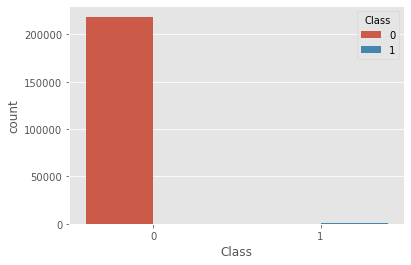

In [9]:
sns.countplot(x = 'Class', hue = 'Class', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above chart, we see that the data is an extreme imbalanced (~99.8% are 0s and ~0.2% are 1s).</div>

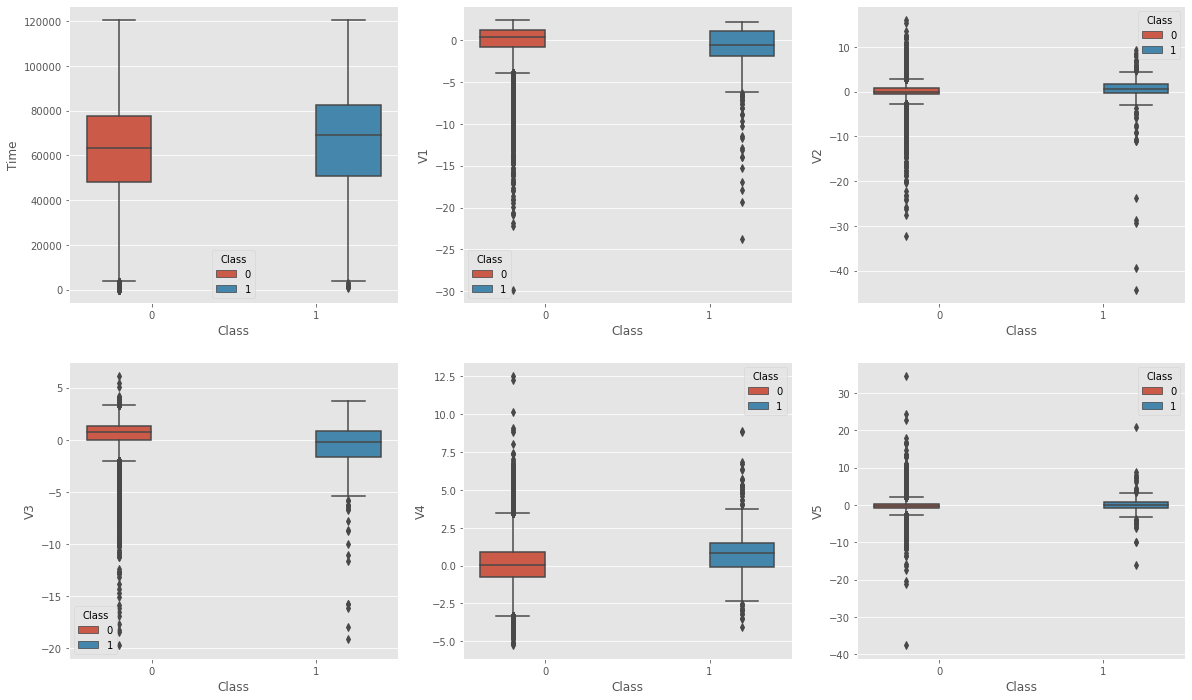

In [10]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], x = 'Class', y = 'Time', hue = 'Class', data = train)
sns.boxplot(ax = axes[0, 1], x = 'Class', y = 'V1', hue = 'Class', data = train)
sns.boxplot(ax = axes[0, 2], x = 'Class', y = 'V2', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 0], x = 'Class', y = 'V3', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 1], x = 'Class', y = 'V4', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 2], x = 'Class', y = 'V5', hue = 'Class', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above panels, most of features the have very similar distributions. However, when we compare the medians (of fraud and no-fraud observations) of V3 and V4, it seems that there is a small difference. 
</div>

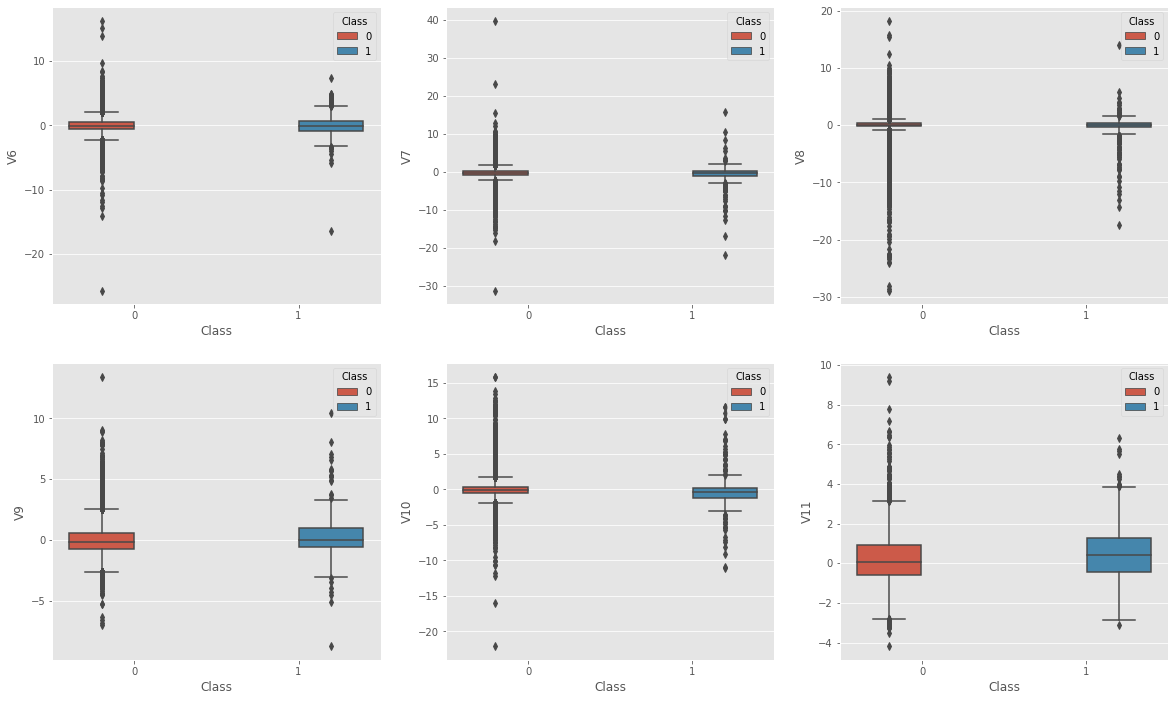

In [11]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], x = 'Class', y = 'V6', hue = 'Class', data = train)
sns.boxplot(ax = axes[0, 1], x = 'Class', y = 'V7', hue = 'Class', data = train)
sns.boxplot(ax = axes[0, 2], x = 'Class', y = 'V8', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 0], x = 'Class', y = 'V9', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 1], x = 'Class', y = 'V10', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 2], x = 'Class', y = 'V11', hue = 'Class', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above panels, most of the features have very similar distributions. However, when we compare the medians (of fraud and no-fraud observations) of V9 and V11, it seems that there is a small difference. 
</div>

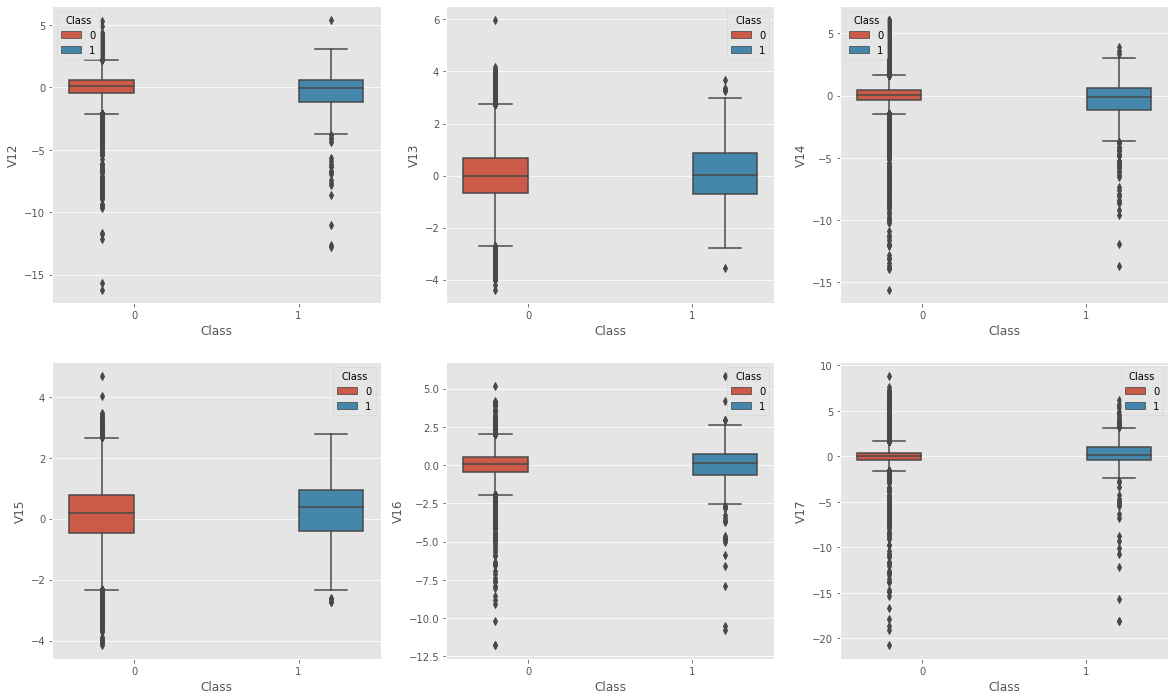

In [12]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], x = 'Class', y = 'V12', hue = 'Class', data = train)
sns.boxplot(ax = axes[0, 1], x = 'Class', y = 'V13', hue = 'Class', data = train)
sns.boxplot(ax = axes[0, 2], x = 'Class', y = 'V14', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 0], x = 'Class', y = 'V15', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 1], x = 'Class', y = 'V16', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 2], x = 'Class', y = 'V17', hue = 'Class', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above panels, most of the features have very similar distributions. However, when we compare the medians (of fraud and no-fraud observations) of V15, it seems that there is a small difference. 
</div>

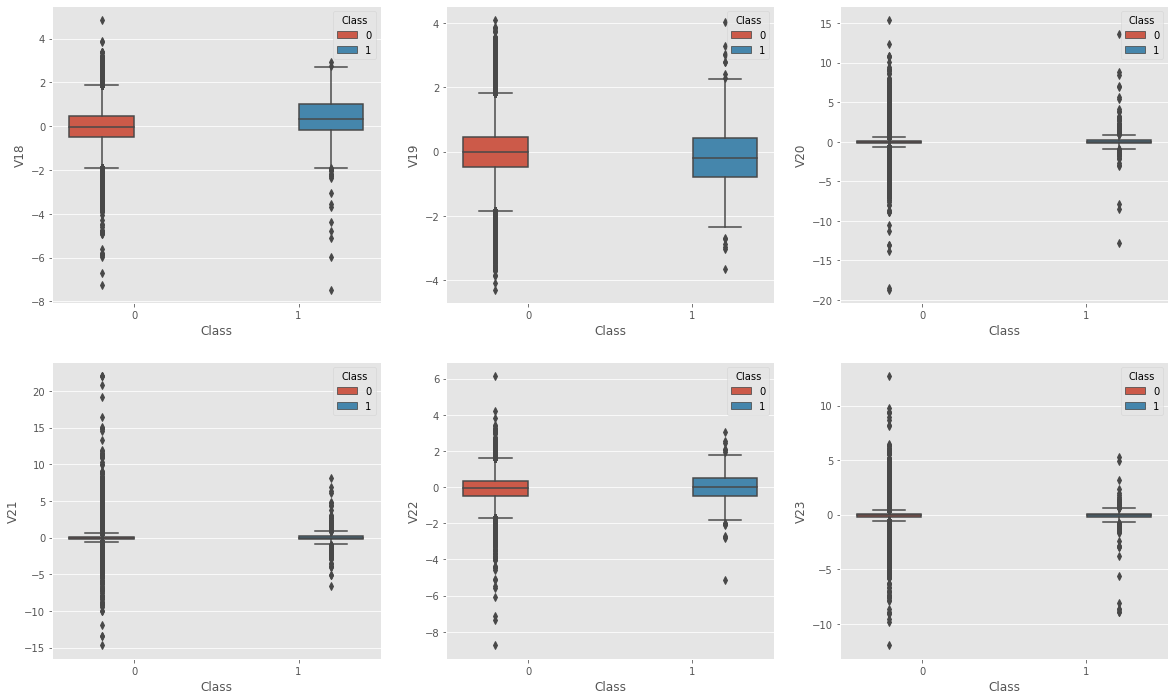

In [13]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], x = 'Class', y = 'V18', hue = 'Class', data = train)
sns.boxplot(ax = axes[0, 1], x = 'Class', y = 'V19', hue = 'Class', data = train)
sns.boxplot(ax = axes[0, 2], x = 'Class', y = 'V20', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 0], x = 'Class', y = 'V21', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 1], x = 'Class', y = 'V22', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 2], x = 'Class', y = 'V23', hue = 'Class', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above panels, most of the features have very similar distributions. However, when we compare the medians (of fraud and no-fraud observations) of V18 and V19, it seems that there is a small difference. 
</div>

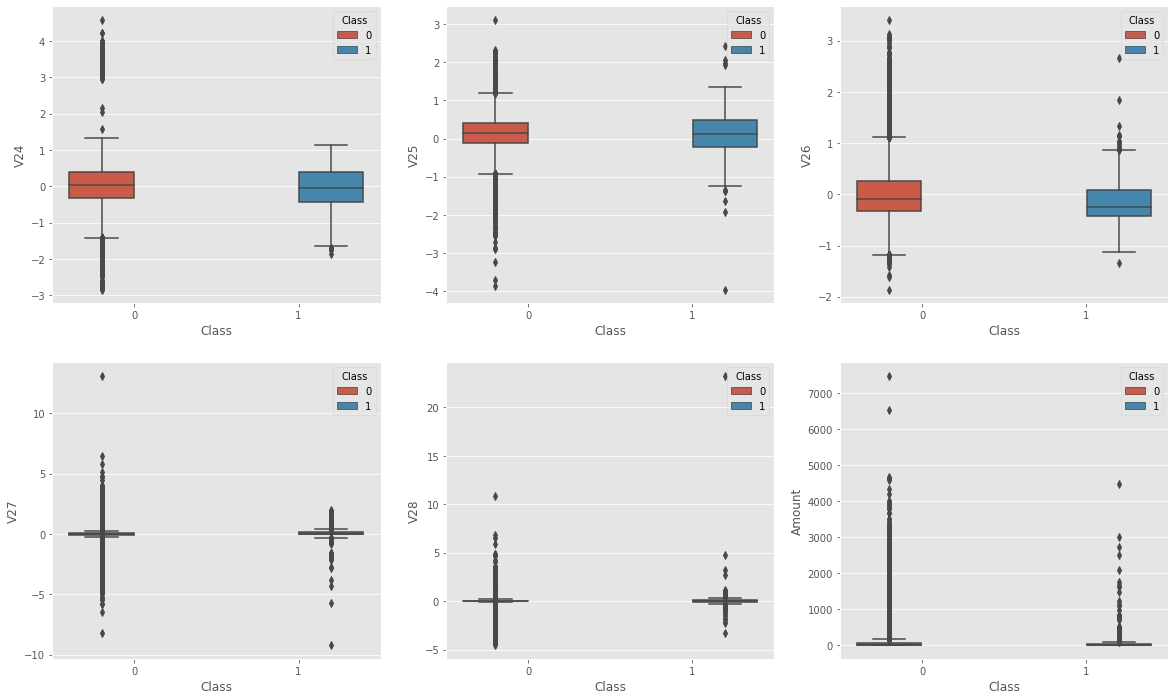

In [14]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], x = 'Class', y = 'V24', hue = 'Class', data = train)
sns.boxplot(ax = axes[0, 1], x = 'Class', y = 'V25', hue = 'Class', data = train)
sns.boxplot(ax = axes[0, 2], x = 'Class', y = 'V26', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 0], x = 'Class', y = 'V27', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 1], x = 'Class', y = 'V28', hue = 'Class', data = train)
sns.boxplot(ax = axes[1, 2], x = 'Class', y = 'Amount', hue = 'Class', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above panels, there is no much to learn because the distribution of the fraud and no-fraud groups are very similar. 
</div>

We next proceed to explore potential correlation among the predictor features.

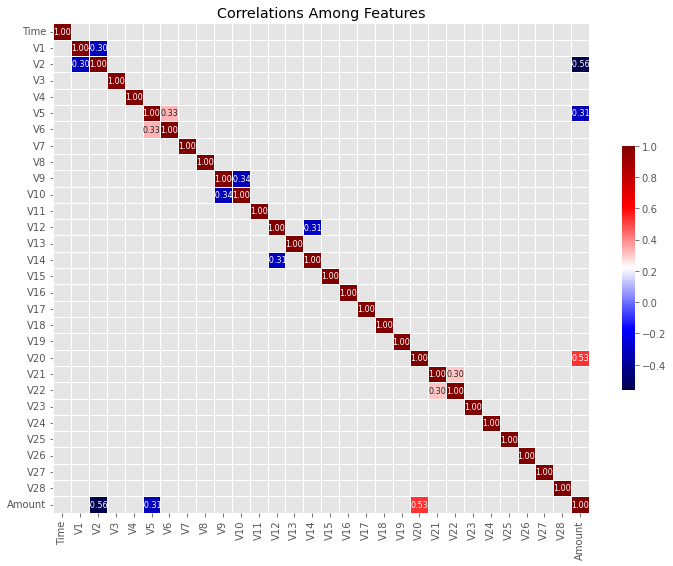

In [15]:
## Explore the correlation between all numerical features
corr_mat = train.drop(columns = ['id', 'Class'], axis = 1).corr()

## Keep only correlation higher than a threshold
threshold = 0.3
corr_threshold = corr_mat[(corr_mat > threshold) | (corr_mat < -threshold)]

plt.figure(figsize = (12, 9))
sns.heatmap(corr_threshold, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths=.5, cbar_kws={'shrink': .5},annot_kws={'size': 8})
plt.title("Correlations Among Features")
plt.show();

> <div class="alert alert-block alert-info">
<b>💡</b> From the above heatmap, V2, V5 and V20 are the features the have the higher correlations with Amount. We also see that:
    <ul>
    <li> V1 and V3 have a correlation of 0.3. </li>
    <li> V9 and V10 have a correlation of 0.31. </li>
    <li> V9 and V10 have a correlation of 0.31. </li>
    <li> V12 and V14 have a correlation of 0.31. </li>  
    <li> V21 and V22 have a correlation of 0.30. </li>    
    </ul>
</div>

We next proceed to compare the distribution of the features in the train and test datasets.

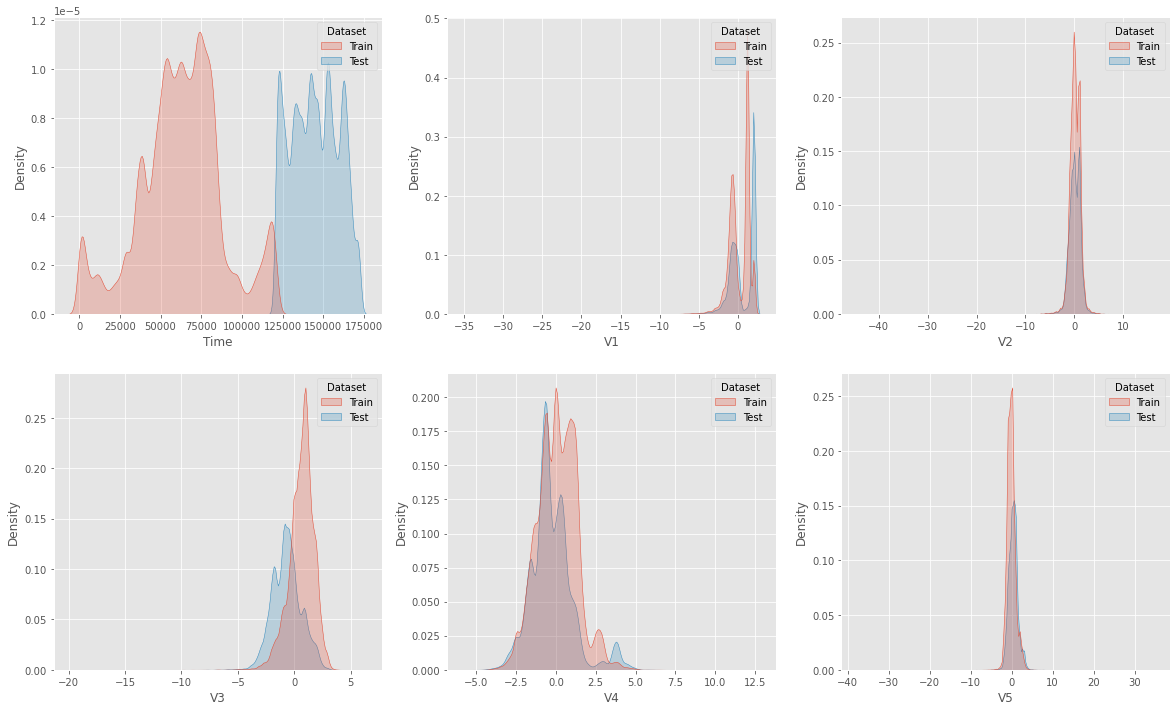

In [16]:
train_vis = train.drop(columns = 'Class', axis = 1).reset_index(drop = True).copy()
test_vis = test.copy()

train_vis['Dataset'] = 'Train'
test_vis['Dataset'] = 'Test'
data_tot = pd.concat([train_vis, test_vis], axis = 0).reset_index(drop = True)

fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.kdeplot(ax = axes[0, 0], x = 'Time', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'V1', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'V2', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'V3', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'V4', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'V5', hue = 'Dataset', data = data_tot, fill = True);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above panels, we see that the distributions of Time are very different in the train and test datasets. Also the distribution of V3 is sligthly different in the train and test datasets.
</div>

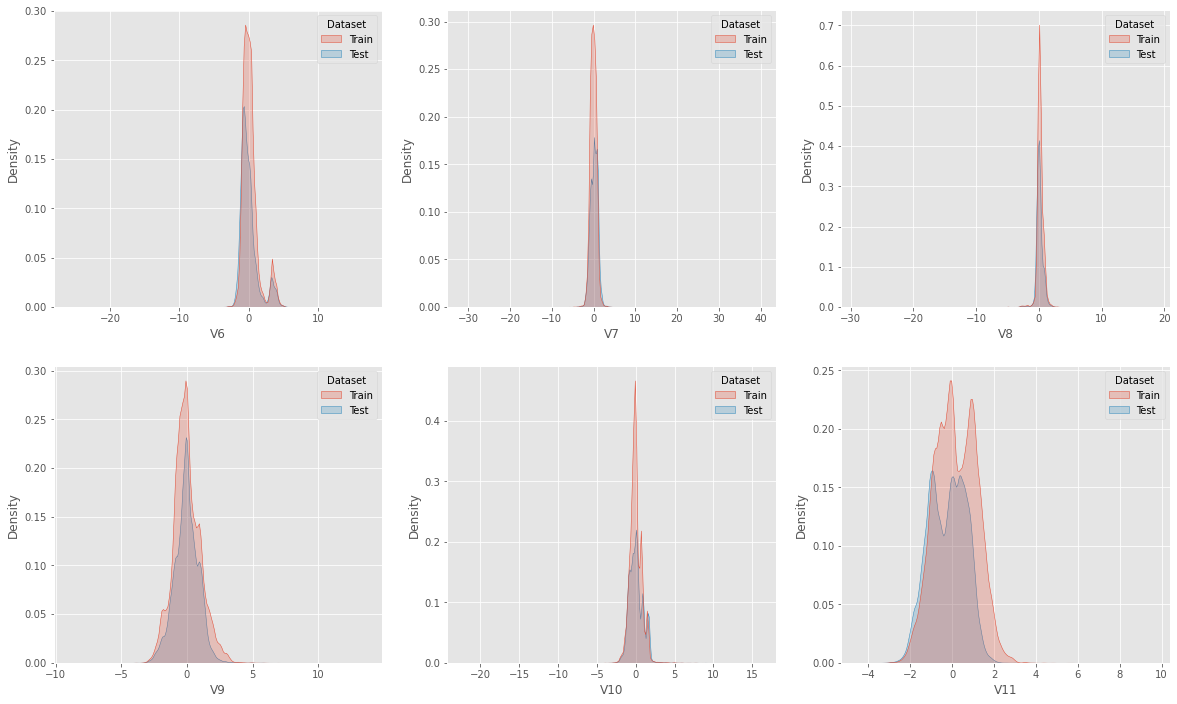

In [17]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.kdeplot(ax = axes[0, 0], x = 'V6', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'V7', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'V8', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'V9', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'V10', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'V11', hue = 'Dataset', data = data_tot, fill = True);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above panels, we see that the distribution of the features and very similar in the train and test datasets.
</div>

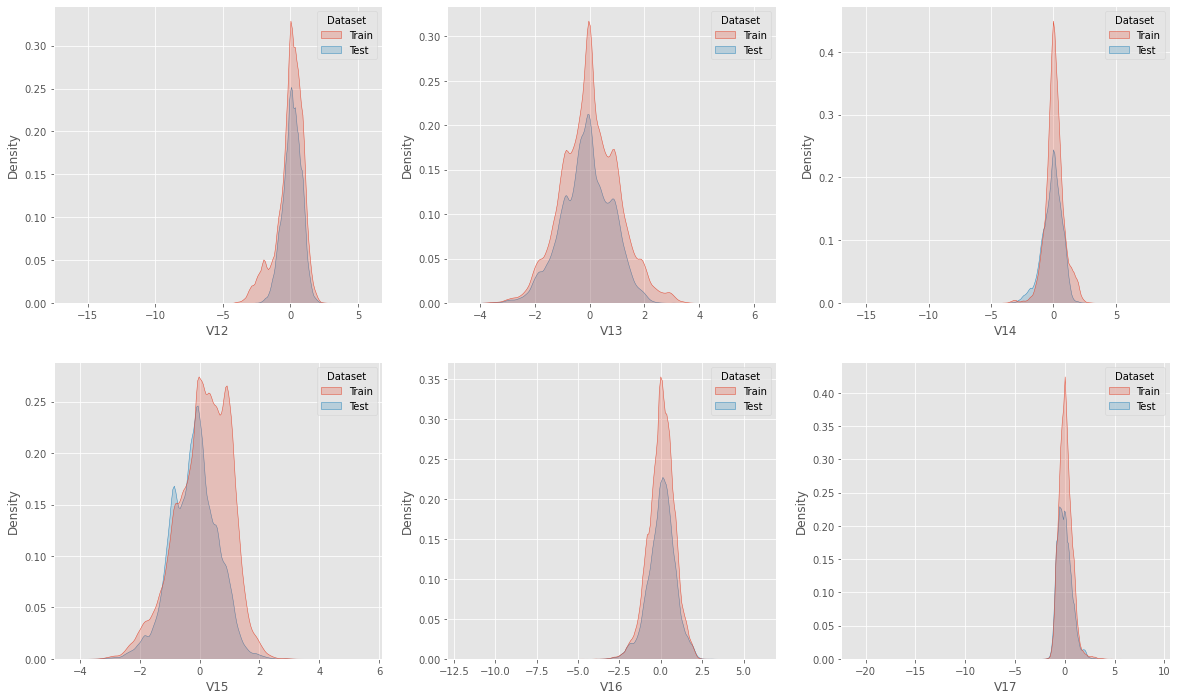

In [18]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.kdeplot(ax = axes[0, 0], x = 'V12', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'V13', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'V14', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'V15', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'V16', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'V17', hue = 'Dataset', data = data_tot, fill = True);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above panels, we see that the distribution of the features and very similar in the train and test datasets.
</div>

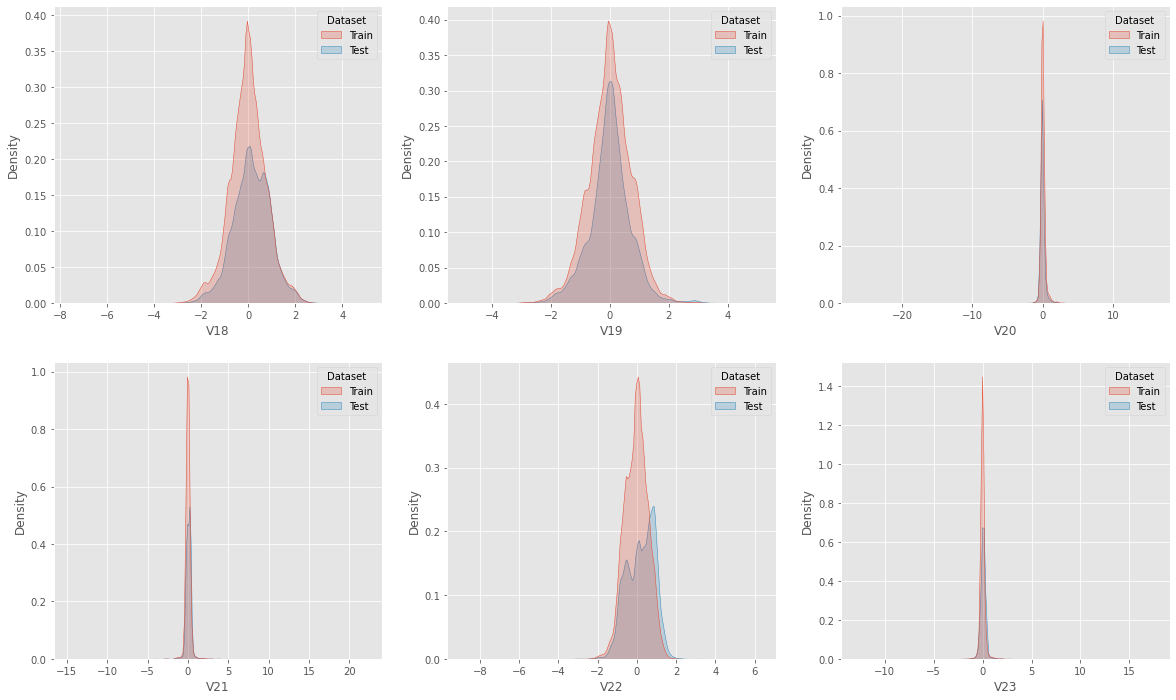

In [19]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.kdeplot(ax = axes[0, 0], x = 'V18', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'V19', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'V20', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'V21', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'V22', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'V23', hue = 'Dataset', data = data_tot, fill = True);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above panels, we see that the distribution of the features and very similar in the train and test datasets.
</div>

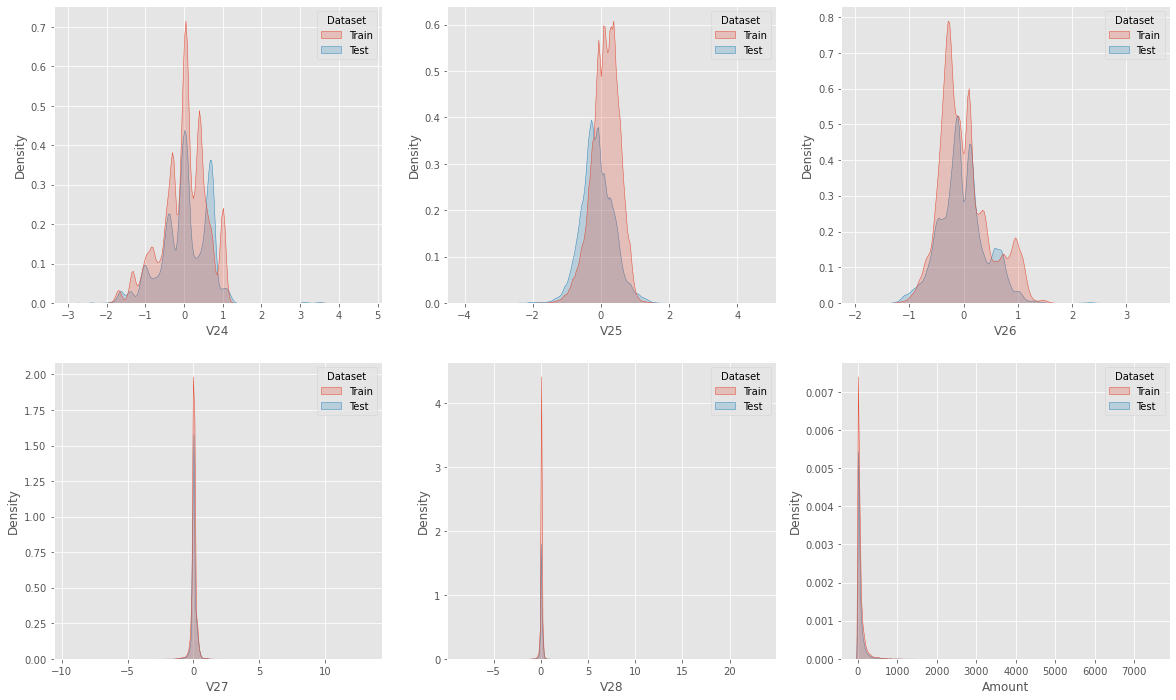

In [20]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.kdeplot(ax = axes[0, 0], x = 'V24', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'V25', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'V26', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'V27', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'V28', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'Amount', hue = 'Dataset', data = data_tot, fill = True);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above panels, we see that the distribution of the features and very similar in the train and test datasets.
</div>

<div class="alert alert-block alert-info">
<b>💡 Insights from EDA:</b><br> 
<ul>
    <li> Extreme imbalanced dataset (~99.8% are 0s and ~0.2% are 1s). </li>
    <li> In the train dataset, when we compare the medians (of fraud and no-fraud observations) of V3 and V4, it seems that there is a small difference.  </li>
    <li> In the train dataset, when we compare the medians (of fraud and no-fraud observations) of V9 and V11, it seems that there is a small difference.  </li>
    <li> In the train dataset, when we compare the medians (of fraud and no-fraud observations) of V15, it seems that there is a small difference.  </li>
    <li> In the train dataset, when we compare the medians (of fraud and no-fraud observations) of V18 and V19, it seems that there is a small difference. </li>
    <li> V2 and Amount have a correlation of 0.56. </li>
    <li> V20 and Amount have a correlation of 0.53. </li>
    <li> The distributions of Time are very different in the train and test datasets. </li>
    <li> The distributions of V3 are slighlty different in the train and test datasets. </li>
</ul>
</div>

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">XGBoost Modeling</h1> 

In [21]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']
test = test.drop(columns = 'id', axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'gpu_hist',
                               colsample_bytree = 0.7, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 7, 
                               min_child_weight = 10, 
                               n_estimators = 1000, 
                               subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict_proba(X_test)[:, 1]
        XGB_pred_2 = XGB_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        XGB_cv_scores.append(roc_auc_score(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.8159137157725505


We next proceed to visualize the importance of the features under the XGBoost model. 

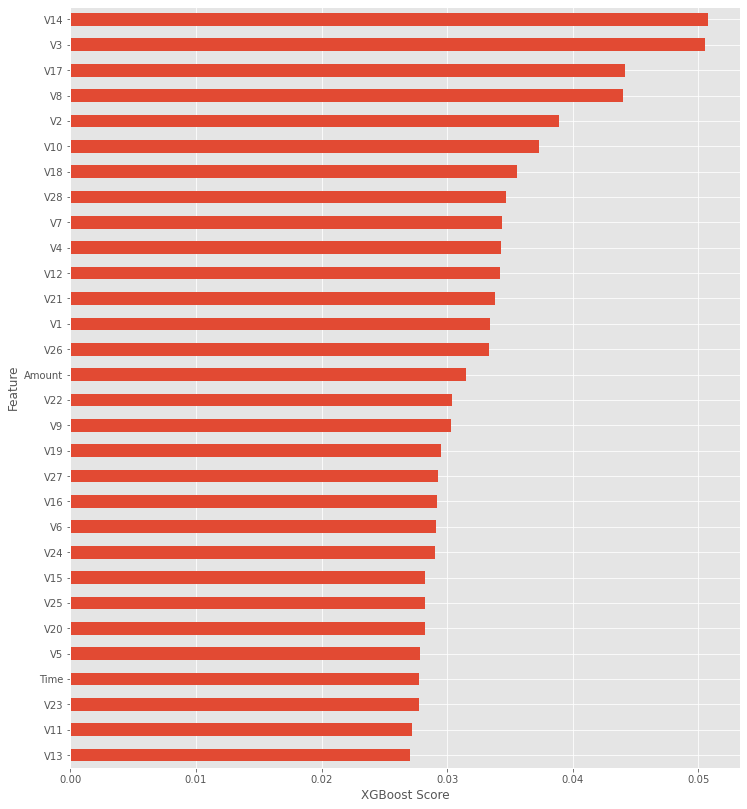

In [22]:
plt.figure(figsize = (12, 14))
pd.DataFrame(XGB_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('XGBoost Score')
plt.ylabel('Feature')
plt.show();

In [23]:
## Building model in the entire train dataset
XGB_md = XGBClassifier(tree_method = 'gpu_hist',
                       colsample_bytree = 0.7, 
                       gamma = 0.8, 
                       learning_rate = 0.01, 
                       max_depth = 7, 
                       min_child_weight = 10, 
                       n_estimators = 1000, 
                       subsample = 0.7).fit(X, Y)

train_preds = pd.DataFrame({'Class': Y, 'Class_pred': XGB_md.predict_proba(X)[:, 1]})
train_preds.head()

,Class,Class_pred
0,0,0.000800
1,0,0.000403
2,0,0.000766
3,0,0.000993
4,0,0.002158


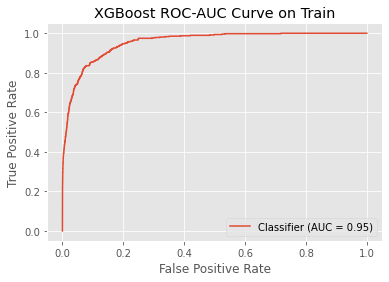

In [24]:
RocCurveDisplay.from_predictions(train_preds['Class'], train_preds['Class_pred'])
plt.title('XGBoost ROC-AUC Curve on Train')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

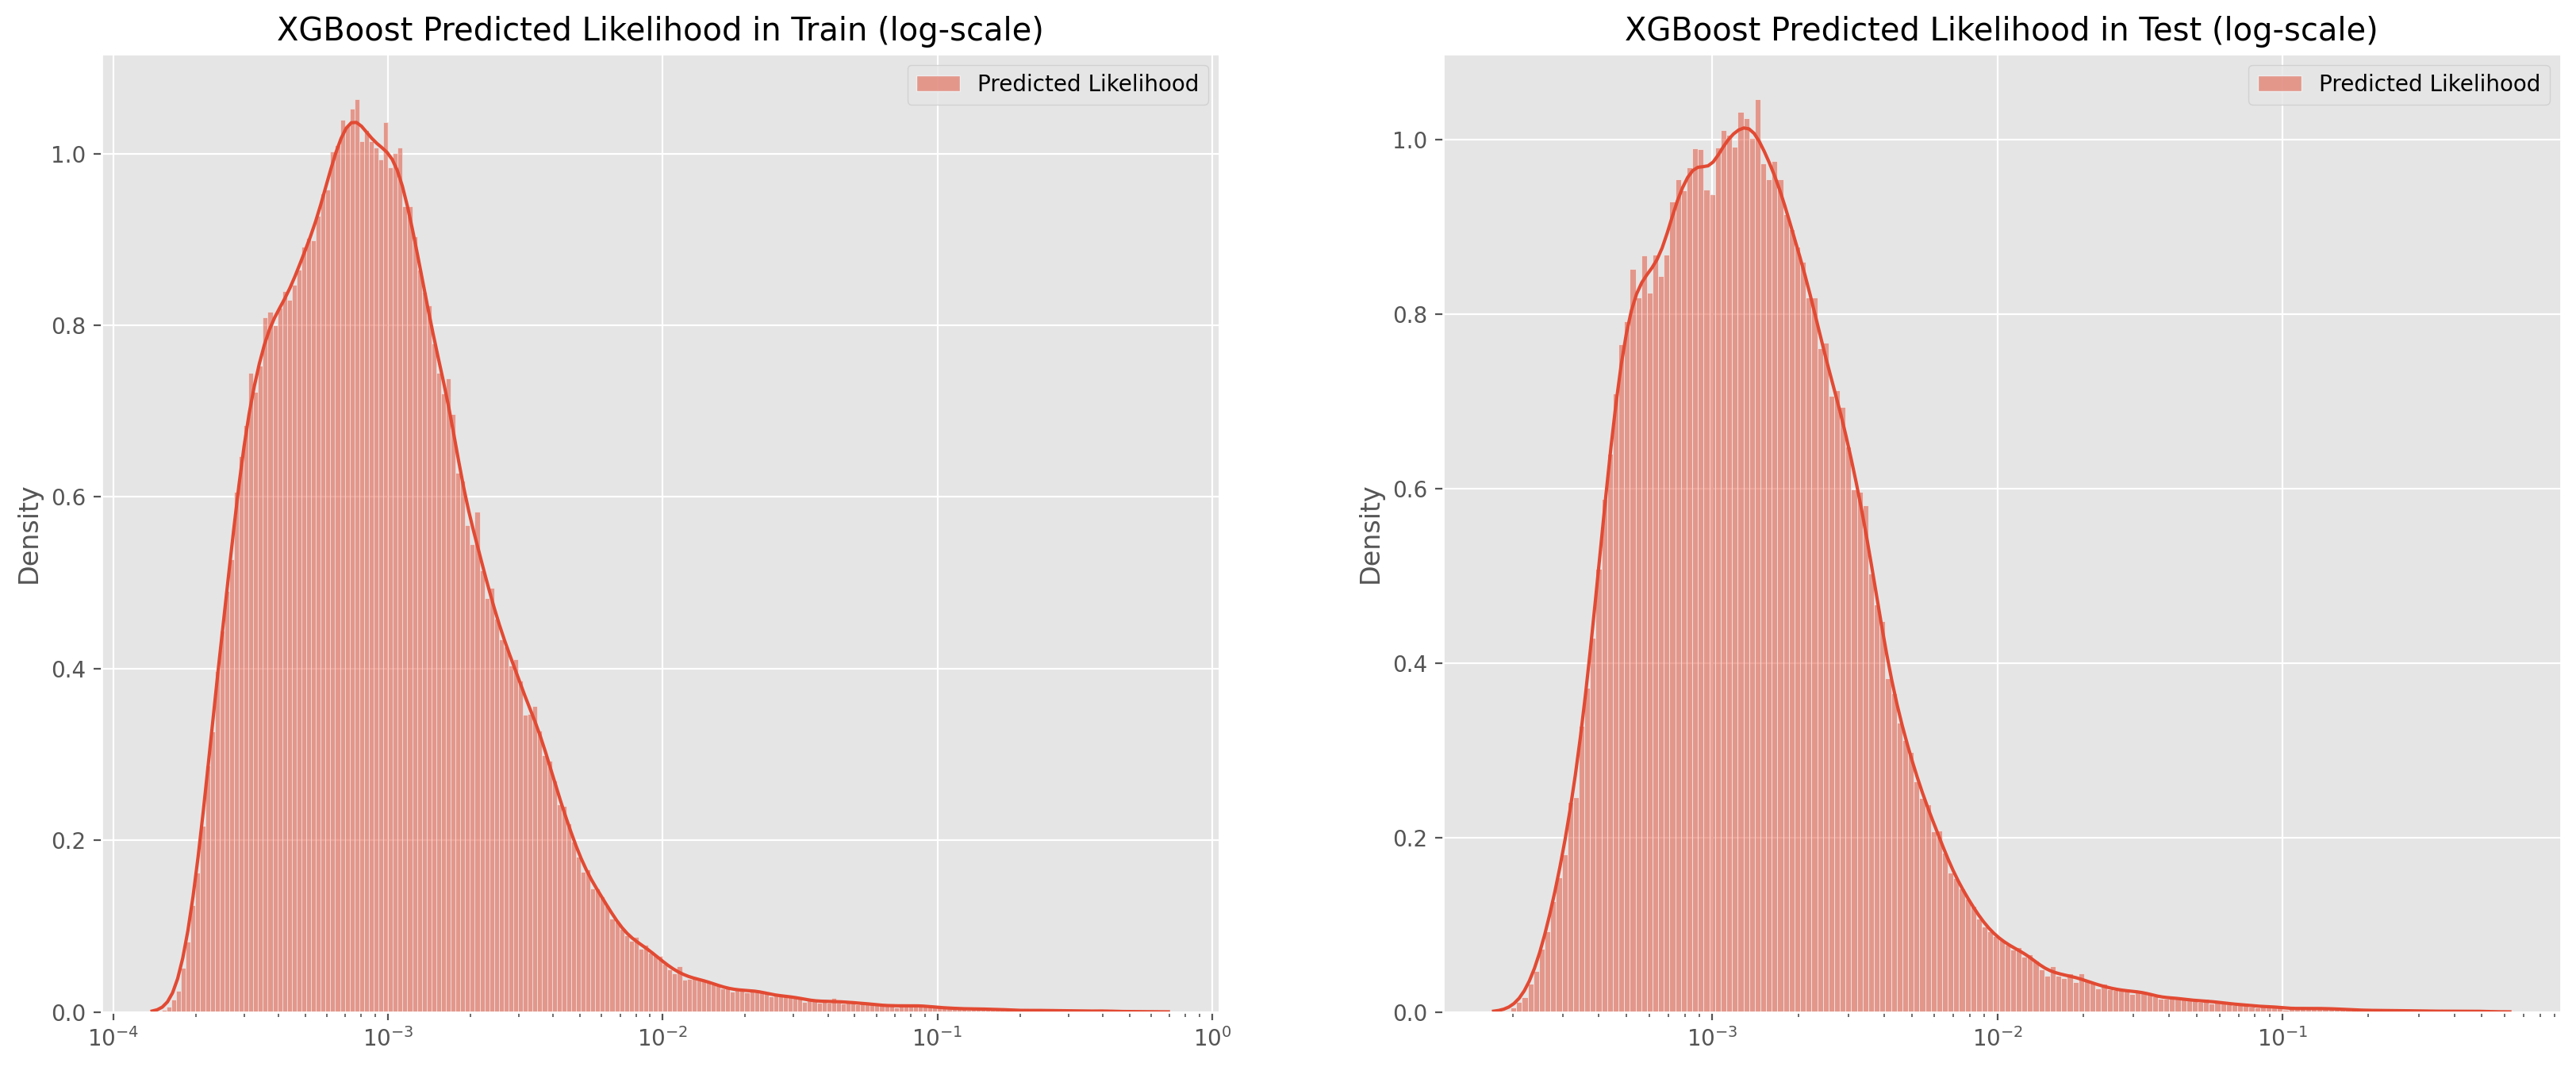

In [25]:
XGB_preds_train = train_preds['Class_pred']
XGB_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

data1 = pd.DataFrame({'Predicted Likelihood': XGB_preds_train})
data2 = pd.DataFrame({'Predicted Likelihood': XGB_preds_test})

fig, axes = plt.subplots(1, 2, figsize = (20, 8), dpi = 200)
sns.histplot(data = data1, kde = True, stat = 'density', ax = axes[0], log_scale = True).set(title = 'XGBoost Predicted Likelihood in Train (log-scale)')
sns.histplot(data = data2, kde = True, stat = 'density', ax = axes[1], log_scale = True).set(title = 'XGBoost Predicted Likelihood in Test (log-scale)')
plt.show();

In [26]:
submission['Class'] = XGB_preds_test
submission.to_csv('XGB_submission.csv', index = False)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">LightGBM Modeling</h1> 

In [27]:
lgb_cv_scores, lgb_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 1000,
                                max_depth = 7,
                                learning_rate = 0.01,
                                num_leaves = 10,
                                lambda_l1 = 3,
                                lambda_l2 = 3,
                                bagging_fraction = 0.7,
                                feature_fraction = 0.7, 
                                device = 'gpu').fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        lgb_cv_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)

lgb_cv_score = np.mean(lgb_cv_scores)    
print('The average oof roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[Li

We next proceed to visualize the importance of the features under the LightGBM model. 

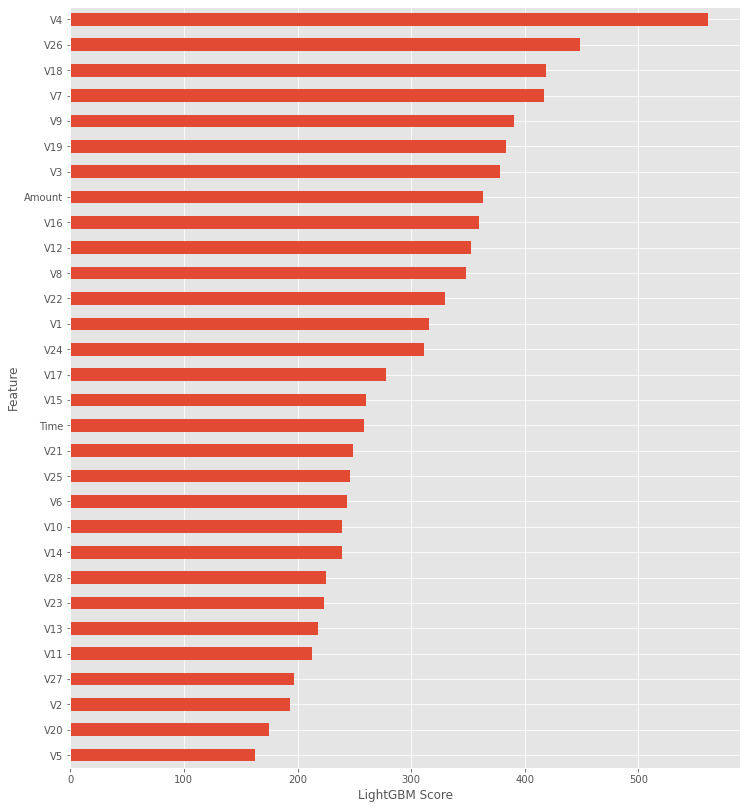

In [28]:
plt.figure(figsize = (12, 14))
pd.DataFrame(lgb_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('LightGBM Score')
plt.ylabel('Feature')
plt.show();

In [29]:
## Building model in the entire train dataset
lgb_md = LGBMClassifier(n_estimators = 1000,
                        max_depth = 7,
                        learning_rate = 0.01,
                        num_leaves = 10,
                        lambda_l1 = 3,
                        lambda_l2 = 3,
                        bagging_fraction = 0.7,
                        feature_fraction = 0.7, 
                        device = 'gpu').fit(X, Y)

train_preds = pd.DataFrame({'Attrition': Y, 'Attrition_pred': lgb_md.predict_proba(X)[:, 1]})
train_preds.head()

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3


,Attrition,Attrition_pred
0,0,0.000916
1,0,0.000496
2,0,0.000596
3,0,0.001196
4,0,0.001568


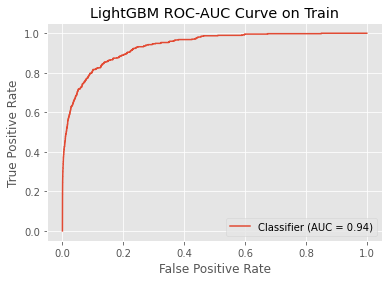

In [30]:
RocCurveDisplay.from_predictions(train_preds['Attrition'], train_preds['Attrition_pred'])
plt.title('LightGBM ROC-AUC Curve on Train')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

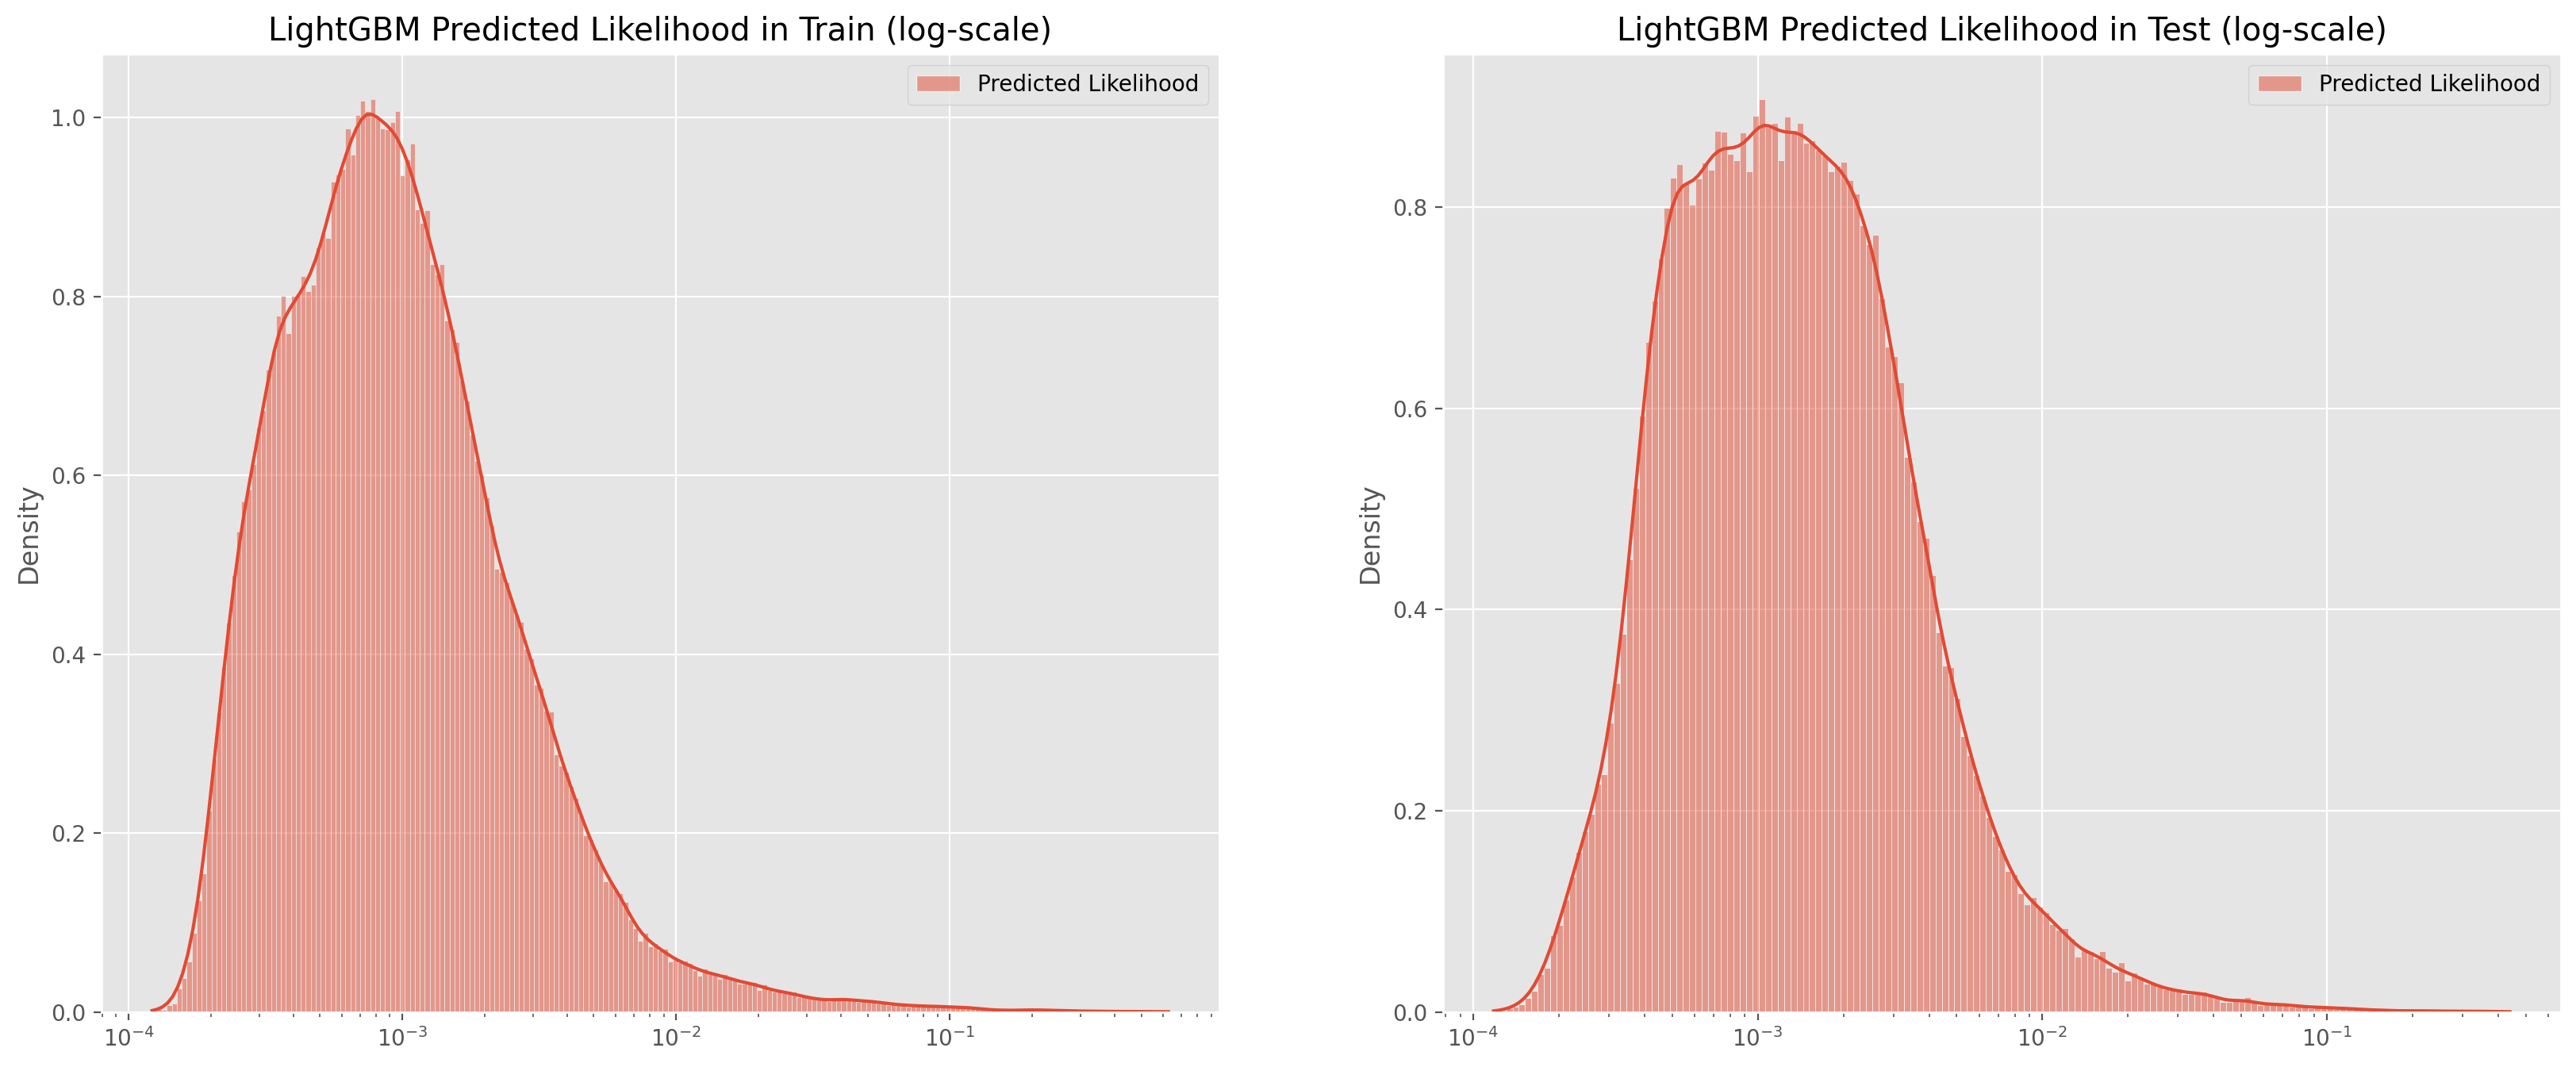

In [31]:
lgb_preds_train = train_preds['Attrition_pred']
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

data1 = pd.DataFrame({'Predicted Likelihood': lgb_preds_train})
data2 = pd.DataFrame({'Predicted Likelihood': lgb_preds_test})

fig, axes = plt.subplots(1, 2, figsize = (20, 8), dpi = 200)
sns.histplot(data = data1, kde = True, stat = 'density', ax = axes[0], log_scale = True).set(title = 'LightGBM Predicted Likelihood in Train (log-scale)')
sns.histplot(data = data2, kde = True, stat = 'density', ax = axes[1], log_scale = True).set(title = 'LightGBM Predicted Likelihood in Test (log-scale)')
plt.show();

In [32]:
submission['Class'] = lgb_preds_test
submission.to_csv('LightGBM_submission.csv', index = False)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Model Performance Comparisson</h1> 

In [33]:
md_scores = pd.DataFrame({'XGB': XGB_cv_scores, 'LightGBM': lgb_cv_scores})
avg_scores = pd.DataFrame(md_scores.apply(np.mean, axis = 0))
# avg_scores['LB'] = [0.81891, 0.82954]
avg_scores.columns = ['Avg. OOF ROC-AUC Score (CV-Score)']
avg_scores

,Avg. OOF ROC-AUC Score (CV-Score)
XGB,0.815914
LightGBM,0.813679


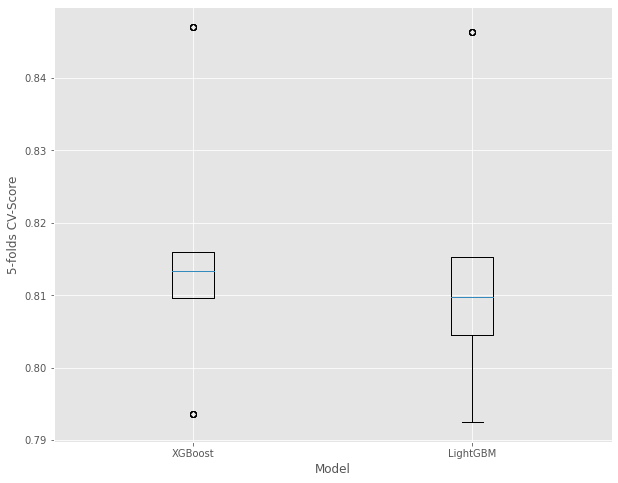

In [34]:
plt.figure(figsize = (10, 8))

plt.boxplot(md_scores, labels = ['XGBoost', 'LightGBM'])
plt.xlabel('Model')
plt.ylabel('5-folds CV-Score');

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Feature Engineering</h1> 

First, we start by taking a close look at the `Time` feature. According to the data description, this feature contains the seconds elapsed between each transaction and the first transaction in the dataset. Let's explore the time distributions in hours.

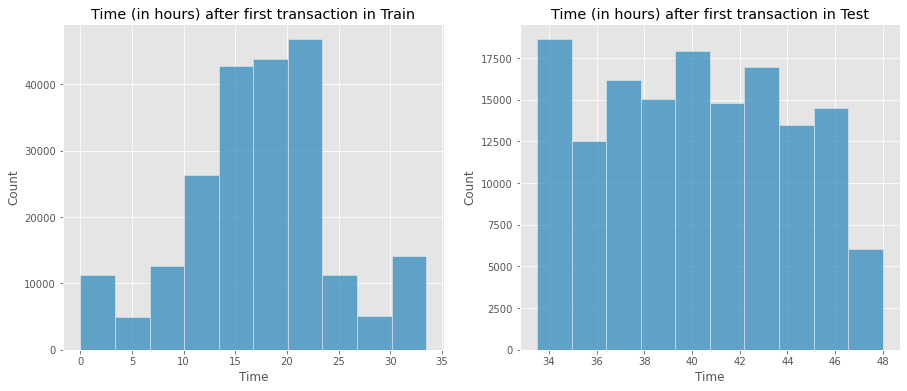

In [35]:
train['Time'] = train['Time'] / 3600
test['Time'] = test['Time'] / 3600

fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.histplot(ax = axes[0], x = 'Time', bins = 10, fill = True, data = train).set_title('Time (in hours) after first transaction in Train')
sns.histplot(ax = axes[1], x = 'Time', bins = 10,  fill = True, data = test).set_title('Time (in hours) after first transaction in Test');

In `Time` distribution in the train dataset, approx. 82\% of the transactions occurred between 7 hours and 25 hours after the first transaction. All these transactions are made by credit cards in September 2013 by European cardholders (according to the original dataset description). Assuming that most of the credit card transactions occur between 12 pm and midnight, we can map the transaction to time-buckets as follows:

| Time (in hours) | Time-Bucket |
| --------------- | ----------- |
| 0-4 | Early Morning |
| 4-10 | Morning |
| 10-16 | Afternoon |
| 16-22 | Night |
| 22-28 | Early Morning |
| 28-34 | Morning |
| 34-40 | Afternoon |
| 40-46 | Night |
| 47-53 | Early Morning | 

Using the above table, we can engineer a time feature. 

In [36]:
train['Time_Label'] = np.where(((train['Time'] >= 0) & (train['Time'] < 4)), 'Early_Morning',
                               np.where(((train['Time'] >= 4) & (train['Time'] < 10)), 'Morning',
                                       np.where(((train['Time'] >= 10) & (train['Time'] < 16)), 'Afternoon',
                                                np.where(((train['Time'] >= 16) & (train['Time'] < 22)), 'Night',
                                                         np.where(((train['Time'] >= 22) & (train['Time'] < 28)), 'Early_Morning', 'Morning')))))

test['Time_Label'] = np.where(((test['Time'] >= 33) & (test['Time'] < 34)), 'Morning', 
                              np.where(((test['Time'] >= 34) & (test['Time'] < 40)), 'Afternoon', 
                                       np.where(((test['Time'] >= 40) & (test['Time'] < 46)), 'Night', 'Early_Morning')))

train_dummies = pd.get_dummies(train['Time_Label'])
test_dummies = pd.get_dummies(test['Time_Label'])

train = pd.concat([train, train_dummies], axis = 1)
train = train.drop(columns = ['Time_Label', 'Morning', 'Afternoon', 'Night'], axis = 1)

test = pd.concat([test, test_dummies], axis = 1)
test = test.drop(columns = ['Time_Label', 'Morning', 'Afternoon', 'Night'], axis = 1)

In [37]:
X = train.drop(columns = ['id', 'Time', 'Class'], axis = 1)
Y = train['Class']

test = test.drop(columns = 'Time', axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'gpu_hist',
                               colsample_bytree = 0.7, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 7, 
                               min_child_weight = 10, 
                               n_estimators = 1000, 
                               subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict_proba(X_test)[:, 1]
        XGB_pred_2 = XGB_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        XGB_cv_scores.append(roc_auc_score(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.8171219707679371


In [38]:
lgb_cv_scores, lgb_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 1000,
                                max_depth = 7,
                                learning_rate = 0.01,
                                num_leaves = 10,
                                lambda_l1 = 3,
                                lambda_l2 = 3,
                                bagging_fraction = 0.7,
                                feature_fraction = 0.7, 
                                device = 'gpu').fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        lgb_cv_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)

lgb_cv_score = np.mean(lgb_cv_scores)    
print('The average oof roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[Li

In [39]:
md_scores = pd.DataFrame({'XGB': XGB_cv_scores, 'LightGBM': lgb_cv_scores})
avg_scores = pd.DataFrame(md_scores.apply(np.mean, axis = 0))
avg_scores.columns = ['Avg. OOF ROC-AUC Score (CV-Score)']
avg_scores

,Avg. OOF ROC-AUC Score (CV-Score)
XGB,0.817122
LightGBM,0.814145


<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;"> Cross Validation (taking into account time)</h1> 

For more details see [here](https://www.kaggle.com/competitions/playground-series-s3e4/discussion/381415).

In [40]:
train = train[(train['Time'] >= 10) & (train['Time'] <= 24)].reset_index(drop = True)

X = train.drop(columns = ['id', 'Time', 'Class'], axis = 1)
Y = train['Class']

# test = test.drop(columns = ['id', 'Time'], axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, shuffle = False)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'gpu_hist',
                               colsample_bytree = 0.7, 
                               gamma = 0.72, 
                               learning_rate = 0.01, 
                               max_depth = 7, 
                               min_child_weight = 10, 
                               n_estimators = 1000, 
                               subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict_proba(X_test)[:, 1]
        XGB_pred_2 = XGB_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        XGB_cv_scores.append(roc_auc_score(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.8203001924208556


In [41]:
submission['Class'] = XGB_preds_test
submission.to_csv('XGB_time_submission.csv', index = False)